In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import datetime as dt
import yfinance as yf
from concurrent.futures import ThreadPoolExecutor

In [47]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from utils.calculations import *
from utils.df_operations import *

In [3]:
html = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = BeautifulSoup(html.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

In [4]:
stock_data = pd.read_html(str(table))[0]

In [5]:
delta_t = pd.tseries.offsets.BusinessDay(n = 21)
end_date = dt.date.today()
start_date = end_date - delta_t

In [6]:
names = [name.replace(".", "-") for name in stock_data.Symbol]
name_query = " ".join(names)

In [11]:
px = yf.download(name_query, start=start_date)
rets = px.pct_change(1)

[*********************100%***********************]  503 of 503 completed

1 Failed download:
- BRK-B: No data found for this date range, symbol may be delisted


In [7]:
tickers = yf.Tickers(name_query)

In [86]:
thread_count = 25
name_count = 100

thread_loop = []

with ThreadPoolExecutor(thread_count) as executor:
    futures = [executor.submit(exp_retrieve, name, thread_loop, tickers) for name in names[:name_count]]
    
with ThreadPoolExecutor(thread_count) as executor:
    futures = [executor.submit(option_retrieve, tick, name, exp, px, rets) for tick, name, exp in thread_loop]
    
opt_chain = pd.concat([future.result() for future in futures]).sort_values(['ticker', 'expiry']).reset_index(drop = True)

In [91]:
test_chain = get_delta_values(opt_chain)
test_chain = test_chain[test_chain['callput'] == 'call']

In [ ]:
rebase_index = np.arange(0.75,1.26,0.01)

In [ ]:
pd.DataFrame(test_chain.groupby('ticker')['volume'].sum().sort_values(ascending=False)[:10])

,volume
ticker,
BMY,39862.0
AAPL,39483.0
AMZN,27234.0
T,24139.0
BAC,23833.0
CCL,18413.0
GOOGL,16870.0
GOOG,15142.0
AIG,8383.0


In [ ]:
ticks = [name for name in test_chain.groupby('ticker')['volume'].sum().sort_values(ascending=False)[:10].index]
d_curve = test_chain[(test_chain['ticker'].isin(ticks)) & (test_chain['expiry'] == '2023-01-20') & (test_chain['callput'] == 'call')]

In [ ]:
curves = pd.DataFrame()

curve_df = pd.DataFrame(columns = ticks, index = rebase_index)

for tick in ticks:
    
    t_curve = d_curve[d_curve['ticker'] == tick][['k_norm', 'delta_calc']].set_index('k_norm')

    interp_curve = pd.DataFrame(np.interp(rebase_index, t_curve.index, t_curve.delta_calc), index = rebase_index)

    curve_df[tick] = interp_curve

<AxesSubplot: >

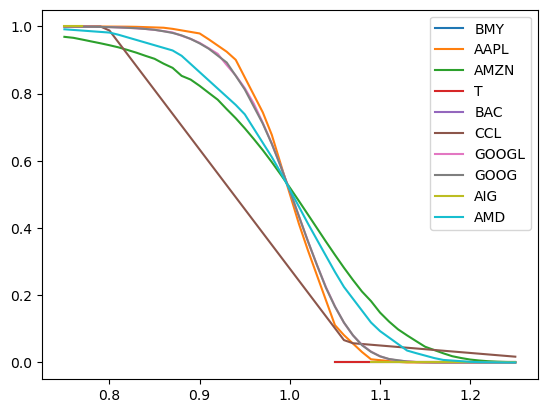

In [ ]:
curve_df.plot()